In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import spacy
from sklearn.metrics import f1_score
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
nlp = spacy.load("en_core_web_sm")

# Loading the train data

In [3]:
df = pd.read_csv('train_file.csv')

In [4]:
df.head(3)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 4 columns):
unique_hash    5279 non-null object
text           5279 non-null object
drug           5279 non-null object
sentiment      5279 non-null int64
dtypes: int64(1), object(3)
memory usage: 165.1+ KB


# To enrich the test data, download and used other available sentiment data 

In [6]:
otherdf = pd.read_csv('alldata.csv',sep="\t",header=None,names=['text','sentiment'])

# Before changing the sentiment label

In [7]:
otherdf['sentiment'].value_counts()

1    1386
0    1362
Name: sentiment, dtype: int64

In [8]:
"""
This other df does not contain any text with neutral sentiment as it has only positive and 
negative sentiment data but the labels are not in sync with our original data lables as 
provided by innoplexus.

Hence we will make all the labels in otherdf as per our original sentiment lables 
i.e
0 --> Positive
1 --> Negative
"""
# Changing the sentiment label as per our data
otherdf['sentiment'] = otherdf['sentiment'].map(lambda x: 0 if x==1 else 1)

In [9]:
# After changing the sentiment label as per our data

In [10]:
otherdf['sentiment'].value_counts()

0    1386
1    1362
Name: sentiment, dtype: int64

##### This adds 2748 more sentiment data to our corpus, and this will help our model to train on a larger dataset

In [11]:
def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

"""
A single text contains mixed sentiment of two drugs but 
we are only intrested in the sentences where the concered drug
is being talked about.

ex: We are talking about two drungs in a paragraph. 
    For Drug A --> Positive Sentiment
    For Drug B --> Negative Sentiment
    We are intersted in the sentiment of Drug B, hence we would like to extract all the sentences 
    from the raw paragraph where drug two is being talked about
"""
def get_relevant_line_old(drug_name, full_text):
    relevant_lines = []
    #print(full_text)
    lines = full_text.split(".")
    #print(lines)
    for line in lines:
        if findWholeWord(drug_name)(line):
            relevant_lines.append(line)
    return ".".join(relevant_lines)

def get_relevant_line(drug_name, full_text):
    global count
    relevant_lines = []
    doc = nlp(full_text)
    lines = list(doc.sents)
    line_str = [str(a) for a in lines]
    for line in line_str:
        if findWholeWord(drug_name)(line):
            relevant_lines.append(line)
    count += 1
    if count % 500 ==0:
        print(count)
    return ".".join(relevant_lines)

# Getting relevant sentences from the text column of raw data

In [12]:
df['relevant_text'] = df[['drug','text']].apply(lambda x: get_relevant_line_old(*x),axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5279 entries, 0 to 5278
Data columns (total 5 columns):
unique_hash      5279 non-null object
text             5279 non-null object
drug             5279 non-null object
sentiment        5279 non-null int64
relevant_text    5279 non-null object
dtypes: int64(1), object(4)
memory usage: 206.3+ KB


In [14]:
# Checking if we have any null columns
df.isna().sum()

unique_hash      0
text             0
drug             0
sentiment        0
relevant_text    0
dtype: int64

In [15]:
df.isnull().sum()

unique_hash      0
text             0
drug             0
sentiment        0
relevant_text    0
dtype: int64

# So we can see that there is no null values in the data

In [16]:
df.head()

,unique_hash,text,drug,sentiment,relevant_text
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,"As for Gilenya – if you feel good, don’t thin..."
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2,You’ve been through some of the unpredictabil...
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2,Interesting that it only targets S1P-1/5 recep...
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2,Now I wonder where lemtrada and ocrevus sales...
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1,There’re no new lesions in Brain/Cord and I’v...


### We are using google's universal sentence encoder to encode both original and other data
    Refrence https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html

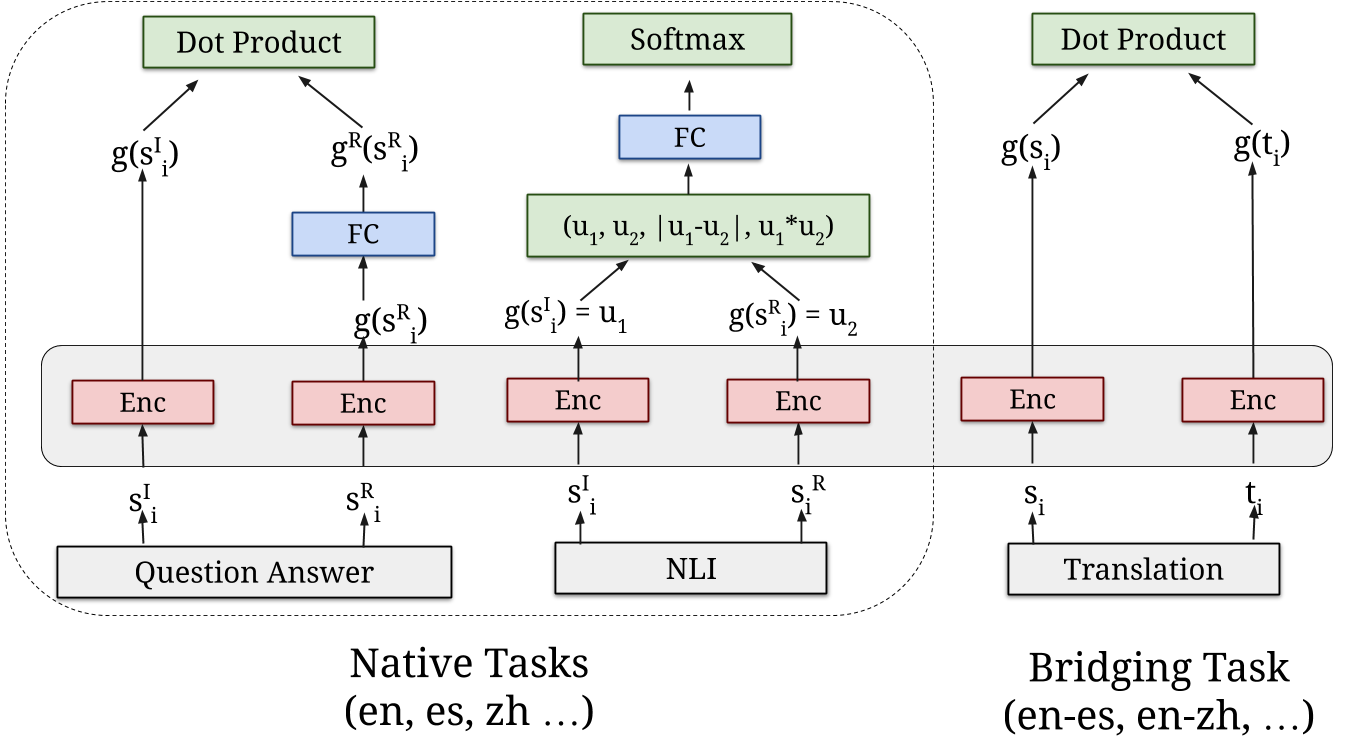

In [17]:
from IPython.core.display import Image, display
url = "https://1.bp.blogspot.com/-1NuvtzSCb3E/XSi8XWLLBQI/AAAAAAAAETM/sl5GOt117d4KsXDy7D2-fJtp92vHiPIlACLcBGAs/s1600/image3.png"
display(Image(url, width=1000, unconfined=True))

In [18]:
df_original_text = list(df['relevant_text'].values)
df_other_text = list(otherdf['text'].values)

In [26]:
len(df_other_text)

2748

In [19]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)
#Getting sentence vector
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embedding_original = session.run(embed(df_original_text))
    message_embedding_otherdf = session.run(embed(df_other_text))
session.close()

In [38]:
# Using google sentence encoder
X = message_embedding_original
y = df['sentiment'].values
X_other = message_embedding_otherdf
y_other = otherdf['sentiment'].values

# Train test split on the test data that we have

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [23]:
print(np.shape(X), np.shape(y1))
print(np.shape(X_train), np.shape(y_train))

(5279, 512) (5279,)
(3695, 512) (3695,)


# Adding the other data into the train set of data

In [24]:
X_merged=np.concatenate((X_train,X_other))
y_merged=np.concatenate((y_train,y_other))
print(X_merged.shape, X_merged.shape)

(6443, 512) (6443, 512)


### Adding another 2748 rows of text will enrich our data.

# Training the random forest classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=500)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [29]:
rf_pred = classifier.predict(X_test)
print(classifier.score(X_train, y_train))
print(classifier.score(X_test , y_test))

0.9964817320703654
0.7329545454545454


In [30]:
f1_score(y_test, rf_pred, average='macro')

0.33927945951370475

`The train test accuracy looks good but the f1 score is low`

# XG Boost

In [31]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
model = XGBClassifier(booster='gblinear')
model.fit(X_train, y_train)
xg_pred = classifier.predict(X_test)

In [32]:
print(model.score(X_train, y_train))
print(model.score(X_test , y_test))

0.725575101488498
0.7222222222222222


In [33]:
f1_score(y_test, xg_pred, average='macro')

0.33927945951370475

` XG Boost looks good with train and test set but there is no improvement in the f1 score which is our prime metric`

# MLP Classifier

In [34]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, warm_start=True)
clf.fit(X_train, y_train) 
mlp_pred = clf.predict(X_test)

# Printing the model accuracy
print(clf.score(X_train, y_train))
print(clf.score(X_test , y_test))

0.9285520974289581
0.69760101010101


/Users/lucifer/software/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [35]:
f1_score(y_test, mlp_pred, average='macro') 

0.46152573834812927

` Multi layer perceptron performs the best so far as per our evaluation metric which is f1 score`

Hence we will be retraing our model on complete train data and the other data which we have downloaded

# Combing data and retraining the MLP Model

In [42]:
print(X.shape, y.shape, X_other.shape, y_other.shape)

(5279, 512) (5279,) (2748, 512) (2748,)


In [43]:
X_final=np.concatenate((X,X_other))
y_final=np.concatenate((y,y_other))
print(X_final.shape, y_final.shape)

(8027, 512) (8027,)


# Now we will retrain our entire model on complete data 

In [44]:
from sklearn.neural_network import MLPClassifier
clf_final = MLPClassifier(hidden_layer_sizes=(100,), max_iter=100, warm_start=True)
clf_final.fit(X_train, y_train) 
mlp_pred = clf_final.predict(X_test)

/Users/lucifer/software/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [45]:
# Printing the model accuracy
print(clf_final.score(X_train, y_train))
print(clf_final.score(X_test , y_test))
f1_score(y_test, mlp_pred, average='macro') 

0.8968876860622462
0.7329545454545454


0.514148150496552

` So we can see that the f1 score improved further but we will not take this as 
a metric because our model has already seen the test set`

# Generating predictions for submission

In [47]:
df_test = pd.read_csv('test_file.csv')
#df_test['relevant_text'] = df_test[['drug','text']].apply(lambda x: get_relevant_line(*x),axis=1)

In [56]:
df_test.head()

,unique_hash,text,drug,relevant_text
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod,"256 (previously stable on natalizumab), with 5..."
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod,On fingolimod and have been since December 201...
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira,"(Yay ) Tried: 5-ASAs, azathioprine, 6MP, Rem..."
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso,"1 year on Tarceva, then 8 months on Rociletin..."
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara,"CC, Stelara worked in a matter of days for me...."


In [51]:
df_test['relevant_text'] = df_test[['drug','text']].apply(lambda x: get_relevant_line_old(*x),axis=1)

In [76]:
test_vec = list(df_test['relevant_text'].values)

In [78]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
embed = hub.Module(module_url)
#Getting sentence vector
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embedding_test = session.run(embed(test_vec))
session.close()

In [79]:
# generating prediction for submission
mlp_pred = clf_final.predict(message_embedding_test)

In [80]:
df_test['sentiment'] = mlp_pred

In [81]:
df_test.head()

,unique_hash,text,drug,relevant_text,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod,"256 (previously stable on natalizumab), with 5...",2
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod,On fingolimod and have been since December 201...,1
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira,"(Yay ) Tried: 5-ASAs, azathioprine, 6MP, Rem...",2
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso,"1 year on Tarceva, then 8 months on Rociletin...",2
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara,"CC, Stelara worked in a matter of days for me....",2


In [82]:
keep_cols = ['unique_hash', 'sentiment']

df_test[keep_cols].to_csv('submission_final.csv', index = False)